In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import warnings

import netCDF4 as nc # used for reading netCDF4 data
import pickle as pkl
import logging

from datetime import datetime , timedelta

import enum

import glob

%matplotlib inline

np.set_printoptions(precision=3, linewidth=80, edgeitems=1) # make numpy less verbose
xr.set_options(display_width=70)
warnings.simplefilter('ignore') # filter some warning messages

In [3]:
ds = xr.tutorial.load_dataset('air_temperature')
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 ... 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day)...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.nc...

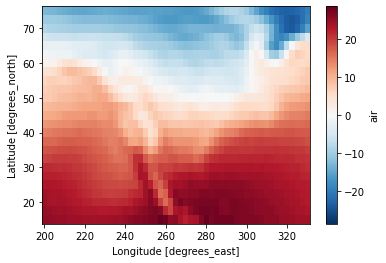

In [12]:
kelvin = ds.air.mean(dim='time')

celcius = kelvin - 273.15
celcius.plot()
 Note that we will extract 4 time steps! 3d data is plotted as histogram

In [19]:
WRITE_PATH = '/gpfs/work1/0/ctdas/awoude/Ritten/predictor_vars/'
VAR_DATA_PATH = '/projects/0/tm5meteo/tm5-nc/ec/ea/h06h18tr1/sfc/glb100x100/'

def date_to_filename(date, param_name):
    return VAR_DATA_PATH + str(date.year) + '/' + param_name + '_' + date.strftime('%Y%m%d') + '_00p01.nc'

dates = [pd.to_datetime(i, format='%Y%m%d') for i in range(20000101, 20000130)]

dates_2 = [pd.to_datetime(i, format='%Y%m%d') for i in range(20010101, 20010130)]
print(dates)

[Timestamp('2000-01-01 00:00:00'), Timestamp('2000-01-02 00:00:00'), Timestamp('2000-01-03 00:00:00'), Timestamp('2000-01-04 00:00:00'), Timestamp('2000-01-05 00:00:00'), Timestamp('2000-01-06 00:00:00'), Timestamp('2000-01-07 00:00:00'), Timestamp('2000-01-08 00:00:00'), Timestamp('2000-01-09 00:00:00'), Timestamp('2000-01-10 00:00:00'), Timestamp('2000-01-11 00:00:00'), Timestamp('2000-01-12 00:00:00'), Timestamp('2000-01-13 00:00:00'), Timestamp('2000-01-14 00:00:00'), Timestamp('2000-01-15 00:00:00'), Timestamp('2000-01-16 00:00:00'), Timestamp('2000-01-17 00:00:00'), Timestamp('2000-01-18 00:00:00'), Timestamp('2000-01-19 00:00:00'), Timestamp('2000-01-20 00:00:00'), Timestamp('2000-01-21 00:00:00'), Timestamp('2000-01-22 00:00:00'), Timestamp('2000-01-23 00:00:00'), Timestamp('2000-01-24 00:00:00'), Timestamp('2000-01-25 00:00:00'), Timestamp('2000-01-26 00:00:00'), Timestamp('2000-01-27 00:00:00'), Timestamp('2000-01-28 00:00:00'), Timestamp('2000-01-29 00:00:00')]


In [20]:
lsp = {}
t2m = {}
for date in dates:
    with nc.Dataset(date_to_filename(date,'lsp')) as ds:
        d = xr.DataArray(name='lsp', data=np.sum(ds['lsp'][:], axis=0).astype(np.float32), dims=['lat','lon'], coords={'lon':np.arange(ds.lonmin,ds.lonmax+1, 1), 'lat':np.arange(ds.latmin,ds.latmax+1,1)})
        lsp[date] = d
    with nc.Dataset(date_to_filename(date,'t2m')) as ds:
        d = xr.DataArray(name='t2m', data=np.sum(ds['t2m'][:], axis=0).astype(np.float32), dims=['lat','lon'], coords={'lon':np.arange(ds.lonmin,ds.lonmax+1, 1), 'lat':np.arange(ds.latmin,ds.latmax+1,1)})
        t2m[date] = d

lsp_2 = {}
t2m_2 = {}
for date in dates_2:
    with nc.Dataset(date_to_filename(date,'lsp')) as ds:
        d = xr.DataArray(name='lsp', data=np.sum(ds['lsp'][:], axis=0).astype(np.float32), dims=['lat','lon'], coords={'lon':np.arange(ds.lonmin,ds.lonmax+1, 1), 'lat':np.arange(ds.latmin,ds.latmax+1,1)})
        lsp_2[date] = d
    with nc.Dataset(date_to_filename(date,'t2m')) as ds:
        d = xr.DataArray(name='t2m', data=np.sum(ds['t2m'][:], axis=0).astype(np.float32), dims=['lat','lon'], coords={'lon':np.arange(ds.lonmin,ds.lonmax+1, 1), 'lat':np.arange(ds.latmin,ds.latmax+1,1)})
        t2m_2[date] = d

In [21]:
lsp_dat_arr = xr.concat(list(lsp.values()), pd.Index(list(lsp.keys()), name="time"))
t2m_dat_arr = xr.concat(list(t2m.values()), pd.Index(list(t2m.keys()), name="time"))

lsp_dat_arr_2 = xr.concat(list(lsp_2.values()), pd.Index(list(lsp_2.keys()), name="time"))
t2m_dat_arr_2 = xr.concat(list(t2m_2.values()), pd.Index(list(t2m_2.keys()), name="time"))

In [58]:
# print(lsp_dat_arr_2)
# print(t2m_dat_arr_2)

dat_dict = {'lsp': lsp_dat_arr,
           't2m': t2m_dat_arr}

ds = xr.Dataset(None)

ds = xr.merge([ds, xr.Dataset(dat_dict)])
ds = xr.merge([ds,lsp_dat_arr_2])

# print(ds)
ds = xr.merge([ds,t2m_dat_arr_2])
# print(ds)

# print(ds.lsp)
# print(ds.t2m)
print(ds)
# lookup = xr.DataArray([-1, -2, -3, -4, -5], dims=["x"])

# da.where(lookup.isin([-2, -4]), drop=True)
print(ds.isel(time=slice(0,20), lon=slice(0,5), lat=slice(0,2)).to_array())

<xarray.Dataset>
Dimensions:  (time: 58, lon: 360, lat: 180)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2001-01-29
  * lon      (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    lsp      (time, lat, lon) float32 3.097e-09 ... 3.577e-07
    t2m      (time, lat, lon) float32 5.748e+03 ... 6.319e+03
<xarray.DataArray (variable: 2, time: 20, lat: 2, lon: 5)>
array([[[[3.097e-09, 3.097e-09, 3.097e-09, 3.097e-09, 3.097e-09],
         [8.670e-09, 8.670e-09, 8.670e-09, 8.670e-09, 8.670e-09]],

        [[3.782e-08, 3.782e-08, 3.782e-08, 3.782e-08, 3.782e-08],
         [3.653e-08, 3.653e-08, 3.653e-08, 3.653e-08, 3.653e-08]],

        [[8.679e-08, 8.679e-08, 8.679e-08, 8.679e-08, 8.679e-08],
         [1.251e-07, 1.251e-07, 1.251e-07, 1.251e-07, 1.251e-07]],

        [[5.365e-09, 5.365e-09, 5.365e-09, 5.365e-09, 5.365e-09],
         [2.881e-08, 2.881e-08, 2.881e-08, 2.881e-08, 2.88

In [35]:
print(a)

<xarray.DataArray (lat: 180, lon: 360, time: 29)>
array([[[3.097e-09, ..., 1.549e-10],
        ...,
        [2.297e-09, ..., 2.065e-10]],

       ...,

       [[2.852e-07, ..., 2.752e-08],
        ...,
        [2.862e-07, ..., 2.737e-08]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-29
  * lon      (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5


In [32]:
with nc.Dataset(date_to_filename(date,'lsp')) as ds:
    print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.4
    title: TM meteo file
    institution: TM community
    source: TM produced meteo file
    history: None
    references: None
    comment: None
    tmm_format: tm5-nc
    tmm_gridtype: ll
    grav: 9.80665
    ae: 6371000.0
    lonmin: -179.5
    lonmax: 179.5
    latmin: -89.5
    latmax: 89.5
    dimensions(sizes): nv(2), lon(360), lat(180), time(24), timeval(6)
    variables(dimensions): float64 lon(lon), float64 lon_bounds(lon, nv), float64 lat(lat), float64 lat_bounds(lat, nv), float32 cell_area(lat, lon), float64 time(time), float64 time_bounds(time, nv), float64 reftime(time), int32 timevalues(time, timeval), int32 timevalues_bounds(time, timeval, nv), int32 reftimevalues(time, timeval), float32 lsp(time, lat, lon)
    groups: 
